In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [2]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'install_rate', 'personal_status', 'debtors', 'residence', 'property', 'age', 'install_plans', 'housing', 'num_credits', 'job', 'num_liable', 'telephone', 'foreign_worker', 'credit']
df = pd.read_table('german.data', names=cols, sep=" ", index_col=False)

**Pre-processing** (categorical to numerical)

In [3]:
 def preprocess(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3    
    
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)    
    df = pd.concat([df, pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)

    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2    
    
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)    
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)        
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['housing'], prefix='housing')],axis=1)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)    
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    
    df['credit'] = df['credit'].replace(2, 0) #1 = Good, 2= Bad credit risk

#     process age
#     df.loc[(df['age'] >= 15) & (df['age'] <= 24) , 'age'] = 0
#     df.loc[(df['age'] >= 25) & (df['age'] <= 34) , 'age'] = 1
#     df.loc[(df['age'] >= 35) & (df['age'] <= 44) , 'age'] = 2
#     df.loc[(df['age'] >= 45) & (df['age'] <= 54) , 'age'] = 3
#     df.loc[(df['age'] >= 55) & (df['age'] <= 64) , 'age'] = 4
#     df.loc[(df['age'] >= 65) , 'age'] = 5

    return df

df = preprocess(df)
df_orig = copy.deepcopy(df)

y = df['credit']
df = df.drop(columns=['purpose', 'personal_status', 'housing', 'credit'])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender'=0
# privileged: 'gender'=1

# protected: 'age'=0
# privileged: 'age'=1

**Parametric Model**

In [5]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute fairness metric**

In [6]:
def computeFairness(y_pred, X_test, y_test, metric): 
    fairnessMetric = 0
    protected_idx = X_test[X_test['age']==0].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['age']==1].index
    numPrivileged = len(privileged_idx)
        
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    # statistical parity difference
    statistical_parity = p_protected - p_privileged
    
    # equality of opportunity, or 
    # true positive rate parity
    # P(Y=1 | Y=1, G=0)- P(Y=1 | Y=1, G=1)
    true_positive_protected = 0
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            true_positive_protected += y_pred[protected_idx[i]][1]
    tpr_protected = true_positive_protected/actual_positive_protected
    
    true_positive_privileged = 0
    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            true_positive_privileged += y_pred[privileged_idx[i]][1]
    tpr_privileged = true_positive_privileged/actual_positive_privileged
    
    tpr_parity = tpr_protected - tpr_privileged
    
    # equalized odds or TPR parity + FPR parity
    # false positive rate parity
    
    # predictive parity
    p_o1_y1_s1 = 0
    p_o1_s1 = 0
    for i in range(len(protected_idx)):
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        p_o1_s1 += y_pred[protected_idx[i]][1]
        if (y_test[protected_idx[i]] == 1):
            p_o1_y1_s1 += y_pred[protected_idx[i]][1]
    ppv_protected = p_o1_y1_s1/p_o1_s1
    
    p_o1_y1_s0 = 0
    p_o1_s0 = 0
    for i in range(len(privileged_idx)):
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        p_o1_s0 += y_pred[privileged_idx[i]][1]
        if (y_test[privileged_idx[i]] == 1):
            p_o1_y1_s0 += y_pred[privileged_idx[i]][1]
    ppv_privileged = p_o1_y1_s0/p_o1_s0
    
    predictive_parity = ppv_protected - ppv_privileged
    
    if (metric == 0):
        fairnessMetric = statistical_parity
    elif (metric == 1):
        fairnessMetric = tpr_parity
    elif (metric == 2):
        fairnessMetric = predictive_parity
        
    return fairnessMetric

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**Compute Accuracy** 

In [9]:
from sklearn.metrics import accuracy_score

def computeAccuracy(y_true, y_pred):
    accuracy = 0
    for i in range(len(y_true)):
        idx = y_true[i]
        if (y_pred[i][idx] > y_pred[i][1 - idx]):
            accuracy += 1
#         accuracy += y_pred[i][idx]
    accuracy /= len(y_true)
    return accuracy

**First-order derivative of loss function at z with respect to model parameters**

In [10]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

In [11]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i + 1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [12]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [13]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numPrivileged = X_test_orig['age'].sum()
    numProtected = len(X_test_orig) - numPrivileged
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['age'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['age'] == 0:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Computing $v=\nabla($TPR parity difference$)$**

In [14]:
# Return v = del(TPR_parity)/del(theta)
def del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
            del_f_privileged = np.add(del_f_privileged, del_f_i)
    del_f_privileged /= actual_positive_privileged
    
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_protected /= actual_positive_protected

    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Computing $v=\nabla($Predictive parity difference$)$**

In [15]:
# Return v = del(Predictive_parity)/del(theta)
def del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    u_dash_protected = np.zeros((num_params, 1))
    v_protected = 0
    v_dash_protected = np.zeros((num_params, 1))
    u_protected = 0
    for i in range(len(protected_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        v_protected += y_pred[protected_idx[i]][1]
        v_dash_protected = np.add(v_dash_protected, del_f_i)
        if (y_test[protected_idx[i]] == 1):
            u_dash_protected = np.add(u_dash_protected, del_f_i)
            u_protected += y_pred[protected_idx[i]][1]
    del_f_protected = (u_dash_protected * v_protected - u_protected * v_dash_protected)/(v_protected * v_protected)
    
    u_dash_privileged = np.zeros((num_params, 1))
    v_privileged = 0
    v_dash_privileged = np.zeros((num_params, 1))
    u_privileged = 0
    for i in range(len(privileged_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        v_privileged += y_pred[privileged_idx[i]][1]
        v_dash_privileged = np.add(v_dash_privileged, del_f_i)
        if (y_test[privileged_idx[i]] == 1):
            u_dash_privileged = np.add(u_dash_privileged, del_f_i)
            u_privileged += y_pred[privileged_idx[i]][1]
    del_f_privileged = (u_dash_privileged * v_privileged - u_privileged * v_dash_privileged)/(v_privileged * v_privileged)
    
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [16]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    if (size > n):
        size = n
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [17]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Second-order influence computation for a group of points in subset U**

In [18]:
def second_order_influence(X_train, U, size, del_L_del_theta, hessian_all_points):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_U = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
        hessian_U = np.add(hessian_U, s * hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    hinv_del_L_del_theta= np.matmul(hinv_exact, del_L_del_theta_sum)
    hinv_hessian_U = np.matmul(hinv_exact, hessian_U)
    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv_hessian_U, hinv_del_L_del_theta)
    sum_term = np.add(term1, term2)
    return sum_term

**Metrics: Initial state**

In [19]:
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.1122125723372468
Initial TPR parity:  -0.08652218596293249
Initial predictive parity:  -0.09399734636476842
Initial loss:  0.5060895126027029
Initial accuracy:  0.755


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [20]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

*Select delta fairness function depending on selected metric*

In [21]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)

*H^{-1} computation*

In [22]:
hexact = 1
if hexact == 1: 
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)
else: #using Hessian vector product
    size_hvp = int(len(X_train) * .01)
    hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v1, hessian_all_points)

**First-order influence of each training data point**

In [23]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Checking ground truth, first-order and second-order influences for a set**

In [24]:
# if metric == 0:
#     print("Statistical parity ")
# elif metric == 1:
#     print("True positive rate parity ")
# elif metric == 2:
#     print("Predictive parity")
    
# active = 1
# if active:
#     predicates = [ 'age']
#     idx=X_train_orig.index 
#     for pred in predicates:
#        idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
#        idx=idx.intersection(idx0)
      
#     print("#Rows removed: ", len(idx))
#     print("#Rows left: ", len(X_train) - len(idx))
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y)
#     y_pred_test = clf.predict_proba(X_test)
#     print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0)
#     print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1) - tpr_parity_0)
#     print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2) - predictive_parity_0)

#     del_f_1 = 0
#     for i in range(len(idx)):
#         del_f_1 += infs_1[idx[i]]
#     print("First-order influence: ", del_f_1)

#     size_hvp = 1
#     params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
#     print("Second-order influence: ", del_f_2)
    
#     spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
#     print("Ground truth statistical parity after removing subset: ", spd_1)
    
#     tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
#     print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

#     predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
#     print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

#     loss_1 = logistic_loss(y_test, y_pred_test)
#     print("Loss after removing subset: ", loss_1)

#     accuracy_1 = computeAccuracy(y_test, y_pred_test)
#     print("Accuracy after removing subset: ", accuracy_1)

In [25]:
# print(spd_0, tpr_parity_0, preditive_parity_0, loss_0, accuracy_0)
# print(spd_1, tpr_parity_1, predictive_parity_1, loss_1, accuracy_1)

**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [26]:
# print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
# sampleSize = int(.2 * len(X_train))
# for i in range(100):
#     idx = random.sample(range(1, len(X_train)), sampleSize) 
    
#     # Ground truth subset influence
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y)
#     y_pred_test = clf.predict_proba(X_test)
#     inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0
    
#     # First-order subset influence
#     del_f_1 = 0
#     for i in range(len(idx)):
#         del_f_1 += infs_1[idx[i]]
    
#     # Second-order subset influence
#     size_hvp = 1
#     params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    
# #     print(inf_gt, del_f_1, del_f_2, sep=", ")

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

In [27]:
attributes = []
attributeValues = []
second_order_influences = []
gt_influences = []
fractionRows = []

print("Attribute, Value, Ground-truth subset, Add 1st-order inf individual, \
Second-order subset influence, %rowsRemoved, Accuracy")
clf.fit(X_train, y_train)
continuous_cols = ['duration', 'credit_amt', 'install_rate', 'num_credits', 'residence']
for col in X_train_orig.columns:
    if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
        vals = [1]
    else:
        vals = X_train_orig[col].unique()
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 
    
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        inf_gt = 0
        if len(y.unique()) == 1:
            print(col, val)
        if len(y.unique()) > 1:
            # Ground truth subset influence
            clf.fit(X, y)
            y_pred = clf.predict_proba(X_test)
            if metric == 0:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
            elif metric == 1:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1) - tpr_parity_0
            elif metric == 2:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2) - predictive_parity_0
            accuracy = computeAccuracy(y_test, y_pred)

        # First-order subset influence
        del_f_1 = 0            
        for i in range(len(idx)):
            del_f_1 += infs_1[idx[i]]

        # Second-order subset influence
        size_hvp = 1
        params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
        del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
        
        attributes.append(col)
        attributeValues.append(val)
        second_order_influences.append(del_f_2)
        gt_influences.append(inf_gt)
        fractionRows.append(len(idx)/len(X_train)*100)

#         print(col, val, inf_gt, del_f_1, del_f_2, len(idx)/len(X_train), accuracy, sep=", ")

Attribute, Value, Ground-truth subset, Add 1st-order inf individual, Second-order subset influence, %rowsRemoved, Accuracy


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
expl = [attributes, attributeValues, second_order_influences, gt_influences, fractionRows]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["attributes", "attributeValues", "second_order_influences", "gt_influences", "fractionRows"])

explanations['attributes'] = explanations['attributes'].astype(str)
explanations['attributeValues'] = explanations['attributeValues'].astype(int)
explanations['second_order_influences'] = explanations['second_order_influences'].astype(float)
explanations['gt_influences'] = explanations['gt_influences'].astype(float)
explanations['fractionRows'] = explanations['fractionRows'].astype(float)

In [29]:
# explanations.sort_values(by="second_order_influences", ascending=False).head(30)
# explanations.sort_values(by="fractionRows", ascending=False).head(30)

In [30]:
# import scipy.stats as ss
# explanations["gt_rank"] = len(explanations) - ss.rankdata(explanations["gt_influences"])
# explanations["so_rank"] = len(explanations) - ss.rankdata(explanations["second_order_influences"])
# stats.kendalltau(explanations["gt_rank"], explanations["so_rank"])

In [31]:
alpha_f_lower = (-0.01) * (spd_0)
alpha_f_upper = -spd_0
del_f_threshold = (0.0) * spd_0
support = 0.05 # Do not consider extremely small patterns
support_small = 0.3 # For small patterns, 2nd-order estimation is quite accurate
del_f_threshold_small = (-0.1) * (spd_0)
print("alpha_f_lower:", alpha_f_lower)
print("alpha_f_upper:", alpha_f_upper)
print("del_f_threshold:", del_f_threshold)
print("support_small:", support_small)
print("del_f_threshold_small:", del_f_threshold_small)

candidates = explanations[(explanations["second_order_influences"] > alpha_f_lower) 
                           & (explanations["second_order_influences"] < alpha_f_upper)]
candidates = copy.deepcopy(explanations)
candidates.loc[:, 'score'] = candidates.loc[:, 'second_order_influences']*100/candidates.loc[:, 'fractionRows']
# display(candidates)

alpha_f_lower: 0.001122125723372468
alpha_f_upper: 0.1122125723372468
del_f_threshold: -0.0
support_small: 0.3
del_f_threshold_small: 0.01122125723372468


**Lattice generation**

In [32]:
candidates_1 = []
for i in range(len(candidates)):
    candidate = []
    candidate_i = candidates.iloc[i]
#     if ((candidate_i["second_order_influences"] > del_f_threshold) & 
#         (candidate_i["fractionRows"] > support)):
    if ((candidate_i["fractionRows"] > support_small) 
#         or
#        ((candidate_i["fractionRows"] > support) & (candidate_i["second_order_influences"] > del_f_threshold))
       ):
        attr_i = candidate_i["attributes"]
        val_i = str(candidate_i["attributeValues"])
        predicates = []
        predicates.insert(0, attr_i + '=' + str(val_i))
        candidate.insert(0, predicates)
        candidate.insert(1, candidate_i["fractionRows"])
        candidate.insert(2, candidate_i["score"])
        candidate.insert(3, candidate_i["second_order_influences"])
        candidates_1.insert(i, candidate)
print("Generated: ", len(candidates_1), " 1-candidates")
candidates_1.sort()

Generated:  74  1-candidates


In [33]:
%%time
candidates_all = []

# Generating 1-candidates
candidates_1 = []
for i in range(len(candidates)):
    candidate = []
    candidate_i = candidates.iloc[i]
#     if ((candidate_i["second_order_influences"] > del_f_threshold) & 
#         (candidate_i["fractionRows"] > support)):
    if ((candidate_i["fractionRows"] > support_small) or
       ((candidate_i["fractionRows"] > support) & (candidate_i["second_order_influences"] > del_f_threshold))
       ):
        attr_i = candidate_i["attributes"]
        val_i = str(candidate_i["attributeValues"])
        predicates = []
        predicates.insert(0, attr_i + '=' + str(val_i))
        candidate.insert(0, predicates)
        candidate.insert(1, candidate_i["fractionRows"])
        candidate.insert(2, candidate_i["score"])
        candidate.insert(3, candidate_i["second_order_influences"])
        candidates_1.insert(i, candidate)
print("Generated: ", len(candidates_1), " 1-candidates")
candidates_1.sort()
# display(candidates_1)

for i in range(len(candidates_1)):
    if (float(candidates_1[i][2]) > support): # if score > top-k, keep in candidates, not otherwise
        candidates_all.insert(len(candidates_all), candidates_1[i])
    
# Generating 2-candidates
candidates_2 = []
for i in range(len(candidates_1)):
    attr_i = candidates_1[i][0][0].split("=")[0]
    val_i = int(candidates_1[i][0][0].split("=")[1])
    for j in range(i):
        # merge two candidates
        attr_j = candidates_1[j][0][0].split("=")[0]
        val_j = int(candidates_1[j][0][0].split("=")[1])
        
        if (attr_i != attr_j):
            idx = X_train_orig[(X_train_orig[attr_i] == val_i) &
                              (X_train_orig[attr_j] == val_j)].index 
            
            idx_i = X_train_orig[(X_train_orig[attr_i] == val_i)].index 
            idx_j = X_train_orig[(X_train_orig[attr_j] == val_j)].index 
            fractionRows = len(idx)/len(X_train) * 100
            isCompact = True
            if (len(idx) == min(len(idx_i), len(idx_j))): # pattern is not compact if intersection equals one of its parents
                isCompact = False
            if (fractionRows/100 > support):
                X = np.delete(X_train, idx, 0)
                y = y_train.drop(index=idx, inplace=False)

                size_hvp = 1
                params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
                del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
                
                score = del_f_2 * 100/fractionRows
                if ((score > candidates_1[i][2]) & (score > candidates_1[j][2])):

#                 if (
#         #             (del_f_2 > alpha_f_lower) & 
#                     (del_f_2 < alpha_f_upper) & 
#                     (del_f_2 > del_f_threshold)
#                    ):
#                     if (del_f_2 > 0.01):
                        candidate = []
                        predicates = []
                        predicates.insert(0, attr_i + '=' + str(val_i))
                        predicates.insert(1, attr_j + '=' + str(val_j))
                        candidate.insert(0, sorted(predicates, key=itemgetter(0)))                        
                        candidate.insert(1, len(idx)*100/len(X_train))
                        candidate.insert(2, score)
                        candidate.insert(3, del_f_2)
            #             print(candidate)
                        candidates_2.insert(len(candidates_2), candidate)  
                        if (isCompact):
                            candidates_all.insert(len(candidates_all), candidate)
print("Generated: ", len(candidates_2), " 2-candidates")
candidates_2.sort()
# display(candidates_2)

# Recursively generating the rest
candidates_L_1 = copy.deepcopy(candidates_2)
# display(candidates_L_1)
iter=2
while((len(candidates_L_1) > 0) & (iter < 4)):
    print("Generated: ", iter)
#     for i in range(len(candidates_L_1)):
#         candidates_all.insert(len(candidates_all), candidates_L_1[i])
    
    candidates_L = []
    for i in range(len(candidates_L_1)):
        candidate_i = candidates_L_1[i][0]
        for j in range(i):
            candidate_j = candidates_L_1[j][0]
#             print(candidate_i, candidate_j)
            # if L-1 lists intersect
            intersect_candidates = set(candidate_i).intersection(candidate_j)
            if (len(intersect_candidates) == iter - 1):
                setminus_i = list(set(candidate_i) - intersect_candidates)[0].split("=")
                setminus_j = list(set(candidate_j) - intersect_candidates)[0].split("=")
                attr_i = setminus_i[0]
                val_i = int(setminus_i[1])
                attr_j = setminus_j[0]
                val_j = int(setminus_j[1])
                if (attr_i != attr_j):
                    # merge to get L list
                    merged_candidate = list(set(candidate_i + candidate_j))

                    idx_i_j = pd.Index(list(range(len(X_train_orig))))
                    for k in range(len(intersect_candidates)):
                        attr = list(intersect_candidates)[k].split("=")[0]
                        val = int(list(intersect_candidates)[k].split("=")[1])
                        idx_i_j = idx_i_j.intersection(X_train_orig[(X_train_orig[attr] == val)].index)
                    
                    idx_i = idx_i_j.intersection(X_train_orig[(X_train_orig[attr_i] == val_i)].index)
                    idx_j = idx_i_j.intersection(X_train_orig[(X_train_orig[attr_j] == val_j)].index)                    
                    idx = idx_i.intersection(X_train_orig[(X_train_orig[attr_j] == val_j)].index) # merged

                    fractionRows = len(idx)/len(X_train) * 100
                    isCompact = True
                    if (len(idx) == min(len(idx_i), len(idx_j))): # pattern is not compact if intersection equals one of its parents
                        isCompact = False
                    if (fractionRows/100 > support):
                        X = np.delete(X_train, idx, 0)
                        y = y_train.drop(index=idx, inplace=False)

                        size_hvp = 1
                        params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
                        del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    
#                         print(fractionRows)
                        score = del_f_2 * 100/fractionRows
#                         print(score)
#                         print(candidates_L_1[i][2], candidates_L_1[j][2])
                        if (((score > candidates_L_1[i][2]) & (score > candidates_L_1[j][2])) or 
                           (fractionRows > support_small)):
                        
#                         if ((len(idx)/len(X_train) < support_small) &
#                             (del_f_2 < del_f_threshold_small) 
#                             ):
#                             continue
#                             if (
    #                             (del_f_2 > alpha_f_lower) & 
#                                 (del_f_2 > del_f_threshold) 
#                                 &
#                                 (del_f_2 < alpha_f_upper)
#                             ):
                            candidate = []
                            candidate.insert(0, sorted(merged_candidate, key=itemgetter(0)))                        
                            candidate.insert(1, fractionRows)
                            candidate.insert(2, del_f_2*len(X_train)/len(idx))
                            candidate.insert(3, del_f_2)
                            if (candidate not in candidates_L):
#                                     print(candidate_i, candidate_j, "Generated", candidate)
                                candidates_L.insert(len(candidates_L), candidate)
                                if (isCompact):
                                    candidates_all.insert(len(candidates_all), candidate)
    #     print(candidates_L)
    print("Generated:", len(candidates_L), " ", str(iter+1), "-candidates")
    candidates_L_1 = copy.deepcopy(candidates_L)
    candidates_L_1.sort()
    iter += 1

# for i in range(len(candidates_L_1)):
#     candidates_all.insert(len(candidates_all), candidates_L_1[i])
    
#     # display(candidates_all)

Generated:  74  1-candidates
Generated:  277  2-candidates
Generated:  2
Generated: 1190   3 -candidates
Generated:  3
Generated: 2997   4 -candidates
CPU times: user 1min 56s, sys: 481 ms, total: 1min 57s
Wall time: 1min 58s


In [34]:
candidates_support_3_compact = copy.deepcopy(candidates_all)
print(len(candidates_support_3_compact))
candidates_df_3_compact = pd.DataFrame(candidates_support_3_compact, columns=["predicates","support","score","2nd-inf"])
candidates_df_3_compact = candidates_df_3_compact[candidates_df_3_compact["support"] < 20].sort_values(by=['2nd-inf'], ascending=False)
display(candidates_df_3_compact)
# display(candidates_df_3_compact[candidates_df_3_compact["support"] < 20].sort_values(by=['2nd-inf'], ascending=False).head(5))

4381


,predicates,support,score,2nd-inf
2513,"[credit_hist=2, foreign_worker=1, gender=0, nu...",19.000,0.275472,0.052340
930,"[credit_hist=2, gender=0, num_liable=1]",19.125,0.272469,0.052110
328,"[age=1, foreign_worker=1, num_liable=1]",16.750,0.293920,0.049232
3278,"[foreign_worker=1, gender=0, num_liable=1, sav...",18.875,0.257428,0.048590
966,"[gender=0, num_liable=1, savings=0]",19.375,0.247746,0.048001
...,...,...,...,...
2488,"[credit_hist=2, employment=2, foreign_worker=1...",12.500,-0.101689,-0.012711
1502,"[age=0, duration=1, num_credits=1, residence=4]",9.125,-0.157525,-0.014374
1499,"[age=0, credit_amt=1, duration=1, residence=4]",6.500,-0.228992,-0.014885
682,"[age=0, duration=1, residence=4]",13.125,-0.117006,-0.015357


In [35]:
candidates_df_3_compact["2nd-inf"]/0.112182

2513    0.466560
930     0.464511
328     0.438854
3278    0.433131
966     0.427884
          ...   
2488   -0.113308
1502   -0.128133
1499   -0.132682
682    -0.136893
141    -0.183853
Name: 2nd-inf, Length: 4105, dtype: float64

In [36]:
idx = X_train_orig[
                   (X_train_orig['age']==1)
                   & (X_train_orig['gender']==0)                
#                    & (X_train_orig['num_liable']==1)
                   & (X_train_orig['foreign_worker']==1)
                  ].index 

print(len(idx))
print(len(idx)*100/len(X_train))

del_f_1 = 0            
for i in range(len(idx)):
    del_f_1 += infs_1[idx[i]]
print("inf-1", del_f_1)
     
size_hvp = 1
params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]

df_updated = df_orig.drop(index=idx, inplace=False)
# display(df_orig[['credit','age']].groupby(by=["age"]).mean())
# display(df_updated[['credit','age']].groupby(by=["age"]).mean())

X = np.delete(X_train, idx, 0)
y = y_train.drop(index=idx, inplace=False)
clf.fit(X, y)
y_pred = clf.predict_proba(X_test)
print(computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0)

40
5.0
inf-1 0.03553169491608076
0.059739750973001216


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Containment-based filtering (with LSH Ensemble)

In [37]:
def get_subset(X_train_orig, explanation):
    subset = X_train_orig.copy()
    for predicate in explanation:
#         print(predicate)
        attr = predicate.split("=")[0].strip(' ')
        val = int(predicate.split("=")[1].strip(' '))
        subset = subset[subset[attr]==val]
    return subset.index

In [518]:
from datasketch import MinHashLSHEnsemble, MinHash, MinHashLSH
import json


class Topk:
    '''
        top explanations: explanation -> (minhash, set_index, score)
    '''
    def __init__(self, method='lsh', init_df=X_test_orig, init_explanations=[], threshold=0.75, k=5, num_perm=128):
        self.method = method
        self.num_perm = num_perm
        if method == 'lshensemble':
#             self.index = MinHashLSHEnsemble(threshold=threshold, num_perm=num_perm)
#             hashed_explanations = []
#             for explanation, score in init_explanations:
#                 s = get_subset(init_df, explanation)
#                 m = MinHash(num_perm=num_perm)
#                 explanation_json = json.dumps(explanation)
#                 for d in s:
#                     m.update(str(d).encode('utf8'))
#                 hashed_explanations.append((explanation_json, m, len(s)))
#             self.index.index(hashed_explanations)
            raise NotImplementedError
        elif method == 'lsh':
#             self.index = MinHashLSH(threshold=threshold, num_perm=num_perm, params=[64, self.num_perm//64])
#             for explanation, score in init_explanations:
#                 s = get_subset(init_df, explanation)
#                 m = MinHash(num_perm=num_perm)
#                 explanation_json = json.dumps(explanation)
#                 for d in s:
#                     m.update(str(d).encode('utf8'))
#                 self.index.insert(explanation_json, m)
            raise NotImplementedError

        self.top_explanations = dict()
        self.k = k
        self.threshold = threshold
        self.min_score = -100
        self.min_score_explanation =None
    
    def _update_min(self, new_explanation, new_score):
        if len(self.top_explanations) > 0:
            for explanation, t in self.top_explanations.items():
                if t[2] < new_score:
                    new_score = t[2]
                    new_explanation = explanation
        self.min_score = new_score
        self.min_score_explanation = new_explanation
        
    def _containment(self, x, q):
        return len(x & q)/len(q)
            
    def update(self, df, explanation, score):
        if (len(self.top_explanations) < self.k) or (score > self.min_score):
            s = get_subset(df, explanation)
            m = MinHash(num_perm=self.num_perm)
            explanation = json.dumps(explanation)
            for d in s:
                m.update(str(d).encode('utf8'))

            if self.method == 'lshensemble':
#                 q_result = set(self.index.query(m, len(s))).intersection(set(self.top_explanations.keys()))
                raise NotImplementedError
            elif self.method == 'lsh':
#                 q_result = set(self.index.query(m)).intersection(set(self.top_explanations.keys()))
                raise NotImplementedError
            elif self.method == 'containment':
                q_result = set()
                for k, v in self.top_explanations.items():
                    if self._containment(v[1], s) > self.threshold:
#                         print(self._containment(v[1], s))
                        q_result.add(k)
            
#             print(q_result)
#             print([round(len(self.top_explanations[q][1] & s)/len(s), 3) for q in q_result])
#             print([round(len(self.top_explanations[q][1] & s)/len(self.top_explanations[q][1] | s), 3) for q in self.top_explanations.keys()])

            if len(q_result)==0:
                if len(self.top_explanations) <= self.k-1:
                    self._update_min(explanation, score)
                    self.top_explanations[explanation] = (m, s, score)
                    return 0
#                 else:
#                     del self.top_explanations[self.min_score_explanation]
#                     self._update_min(explanation, score)
#                     self.top_explanations[explanation] = (m, s, score)
#                     return 0
#             else:
#                 q_scores = [self.top_explanations[explanation][2] for explanation in q_result]
#                 if max(q_scores) < score:
#                     for explanation in q_result:
#                         del self.top_explanations[explanation]
#                     self._update_min(explanation, score)
#                     self.top_explanations[explanation] = (m, s, score)
# #                     print('Inserted')
#                     return 0
        return -1


In [519]:
lsh_df = candidates_df_3_compact.sort_values(by=['score'], ascending=False).copy()
# init_explanations = [(lsh_df.iloc[row_idx][0], lsh_df.iloc[row_idx][2]) for row_idx in range(100)]

In [520]:
topk = Topk(method='containment', threshold=0.2, k=10)
for row_idx in range(len(lsh_df)):
    row = lsh_df.iloc[row_idx]
    explanation, score = row[0], row[2]
    topk.update(X_train_orig, explanation, score)
    if len(topk.top_explanations) == topk.k:
        break

In [521]:
explanations = list(topk.top_explanations.keys())
idxs = [v[1] for v in topk.top_explanations.values()]
supports = list()
scores = list()
infs = list()
for e in explanations:
    condition = candidates_df_3_compact.predicates.apply(lambda x: x==json.loads(e))
    supports.append(float(candidates_df_3_compact[condition]['support']))
    scores.append(float(candidates_df_3_compact[condition]['score']))
    infs.append(float(candidates_df_3_compact[condition]['2nd-inf']))

expl = [explanations, supports, scores, infs]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["explanations", "support", "score", "2nd-inf"])
explanations['score'] = explanations['score'].astype(float)
explanations['support'] = explanations['support'].astype(float)
explanations['2nd-inf'] = explanations['2nd-inf'].astype(float)

In [479]:
pd.set_option('max_colwidth', 100)
explanations.sort_values(by=['score'], ascending=False)

,explanations,support,score,2nd-inf
0,"[""credit_amt=0"", ""credit_hist=2"", ""gender=0"", ""housing_A152=1""]",6.875,0.516978,0.035542
1,"[""credit_hist=2"", ""job=2"", ""savings=0"", ""telephone=1""]",5.875,0.498851,0.029307
2,"[""age=1"", ""credit_amt=1"", ""num_liable=1""]",5.375,0.496170,0.026669
3,"[""age=1"", ""foreign_worker=1"", ""savings=0"", ""telephone=1""]",5.250,0.423744,0.022247
4,"[""debtors=0"", ""foreign_worker=1"", ""job=3"", ""residence=2""]",5.375,0.422057,0.022686
5,"[""foreign_worker=1"", ""num_liable=1"", ""property=2"", ""status=0""]",6.250,0.407390,0.025462
6,"[""purpose_A46=1""]",4.250,0.407117,0.017302
7,"[""purpose_A48=1""]",0.750,0.373234,0.002799
8,"[""credit_amt=0"", ""credit_hist=0"", ""employment=4"", ""foreign_worker=1""]",5.250,0.367426,0.019290
9,"[""housing_A152=1"", ""num_liable=1"", ""status=1"", ""telephone=1""]",6.375,0.362551,0.023113


In [480]:
candidates_df_3_compact.sort_values(by=['score'], ascending=False).head(10)

,predicates,support,score,2nd-inf
1674,"[credit_amt=0, credit_hist=2, gender=0, housing_A152=1]",6.875,0.516978,0.035542
2622,"[credit_hist=2, gender=0, num_liable=1, telephone=1]",6.000,0.502193,0.030132
2737,"[credit_hist=2, job=2, savings=0, telephone=1]",5.875,0.498851,0.029307
325,"[age=1, credit_amt=1, num_liable=1]",5.375,0.496170,0.026669
1923,"[credit_amt=0, install_rate=4, install_plans=0, status=0]",6.500,0.489595,0.031824
1619,"[age=1, housing_A152=1, install_plans=0, job=2]",6.125,0.477509,0.029247
1615,"[age=1, duration=0, housing_A152=1, install_plans=0]",5.125,0.468263,0.023998
2583,"[credit_hist=2, duration=1, gender=0, housing_A152=1]",5.125,0.463693,0.023764
2620,"[credit_hist=2, gender=0, install_plans=0, telephone=1]",5.750,0.460186,0.026461
1591,"[age=1, credit_hist=2, foreign_worker=1, housing_A152=1]",5.250,0.456259,0.023954


### ground truth containment for filtered top-10 explanations

In [505]:
# row.intersect(column)/column -> percentage of data in column set that also appears in row set
mat = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        if i==j:
            mat[i,j] = 1
        else:
            idx_i = get_subset(X_train_orig,\
                               json.loads(list(explanations.sort_values(by=['score'], ascending=False).explanations)[i]))
            idx_j = get_subset(X_train_orig,\
                               json.loads(list(explanations.sort_values(by=['score'], ascending=False).explanations)[j]))
            mat[i,j] = len(idx_i & idx_j) / len(idx_j)
#             print(json.loads(list(explanations.sort_values(by=['score'], ascending=False).explanations)[i]))


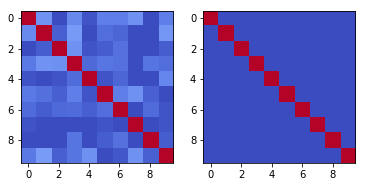

In [508]:
plt.subplot(121)
plt.imshow(mat, cmap=plt.cm.coolwarm)
# plt.colorbar()
plt.subplot(122)
plt.imshow(mat>0.2, cmap=plt.cm.coolwarm)
plt.show()

#### supports are similar, so using Jaccard similarity is also ok

In [498]:
# row.intersect(column)/row.union(column)
mat = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        if i==j:
            mat[i,j] = 1
        else:
            idx_i = get_subset(X_train_orig,\
                               json.loads(list(explanations.sort_values(by=['score'], ascending=False).explanations)[i]))
            idx_j = get_subset(X_train_orig,\
                               json.loads(list(explanations.sort_values(by=['score'], ascending=False).explanations)[j]))
            mat[i,j] = len(idx_i & idx_j) / len(idx_i | idx_j)


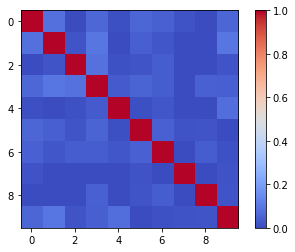

In [499]:
plt.imshow(mat, cmap=plt.cm.coolwarm)
plt.colorbar()
# plt.imshow(mat>0.2, cmap=plt.cm.coolwarm)
plt.show()

### ground truth containment for original top-10 explanations

In [500]:
# row.intersect(column)/column -> percentage of data in column set that also appears in row set
mat = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        if i==j:
            mat[i,j] = 1
        else:
            idx_i = get_subset(X_train_orig, list(candidates_df_3_compact\
                                               .sort_values(by=['score'], ascending=False).predicates)[i])
            idx_j = get_subset(X_train_orig, list(candidates_df_3_compact\
                                               .sort_values(by=['score'], ascending=False).predicates)[j])
            mat[i,j] = len(idx_i & idx_j) / len(idx_j)


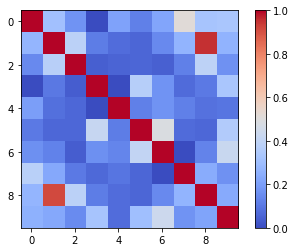

In [501]:
plt.imshow(mat, cmap=plt.cm.coolwarm)
# plt.imshow(mat>0.2, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

#### supports are similar, so using Jaccard similarity is also ok

In [502]:
# row.intersect(column)/row.union(column)
mat = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        if i==j:
            mat[i,j] = 1
        else:
            idx_i = get_subset(X_train_orig, list(candidates_df_3_compact\
                                               .sort_values(by=['score'], ascending=False).predicates)[i])
            idx_j = get_subset(X_train_orig, list(candidates_df_3_compact\
                                               .sort_values(by=['score'], ascending=False).predicates)[j])
            mat[i,j] = len(idx_i & idx_j) / len(idx_i | idx_j)


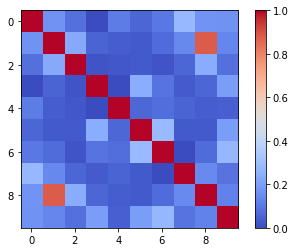

In [503]:
plt.imshow(mat, cmap=plt.cm.coolwarm)
plt.colorbar()
# plt.imshow(mat>0.25, cmap=plt.cm.coolwarm)
plt.show()

## visualization lattice structure

In [509]:
from itertools import combinations

node_dict = dict()
for level in range(1, 5):
    node_dict[level] = set()
    for explanation in list(explanations.sort_values(by=['score'], ascending=False).explanations)[:3]:
        for comb in list(combinations(json.loads(explanation), level)):
            node_dict[level].add(comb)

In [510]:
chr(966)

'φ'

In [511]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

weight = 4
G = nx.DiGraph()
G.add_node(chr(966))
for predicate in node_dict[1]:
    G.add_edge(chr(966), '\n'.join(predicate), weight=weight)
for level in range(2, 5):
    for node in node_dict[level]:
        G.add_node('\n'.join(node))
        for n in node_dict[level-1]:
            if set(n).issubset(set(node)):
                G.add_edge('\n'.join(n), '\n'.join(node), weight=weight)

In [512]:
# calc score for each node
score_dict = dict()
color_map = [0]
for node in G.nodes():
    if node != chr(966):
        idx = get_subset(X_train_orig, node.split('\n'))
        size_hvp = 1
        fractionRows = len(idx)/len(X_train) * 100
        params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
        del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
        score = del_f_2 * 100/fractionRows
        score_dict[node] = round(score, 3)
        color_map.append(round(score, 3))

color_map[0] = (max(list(score_dict.values()))-min(list(score_dict.values())))/2
score_dict[chr(966)] = chr(966)

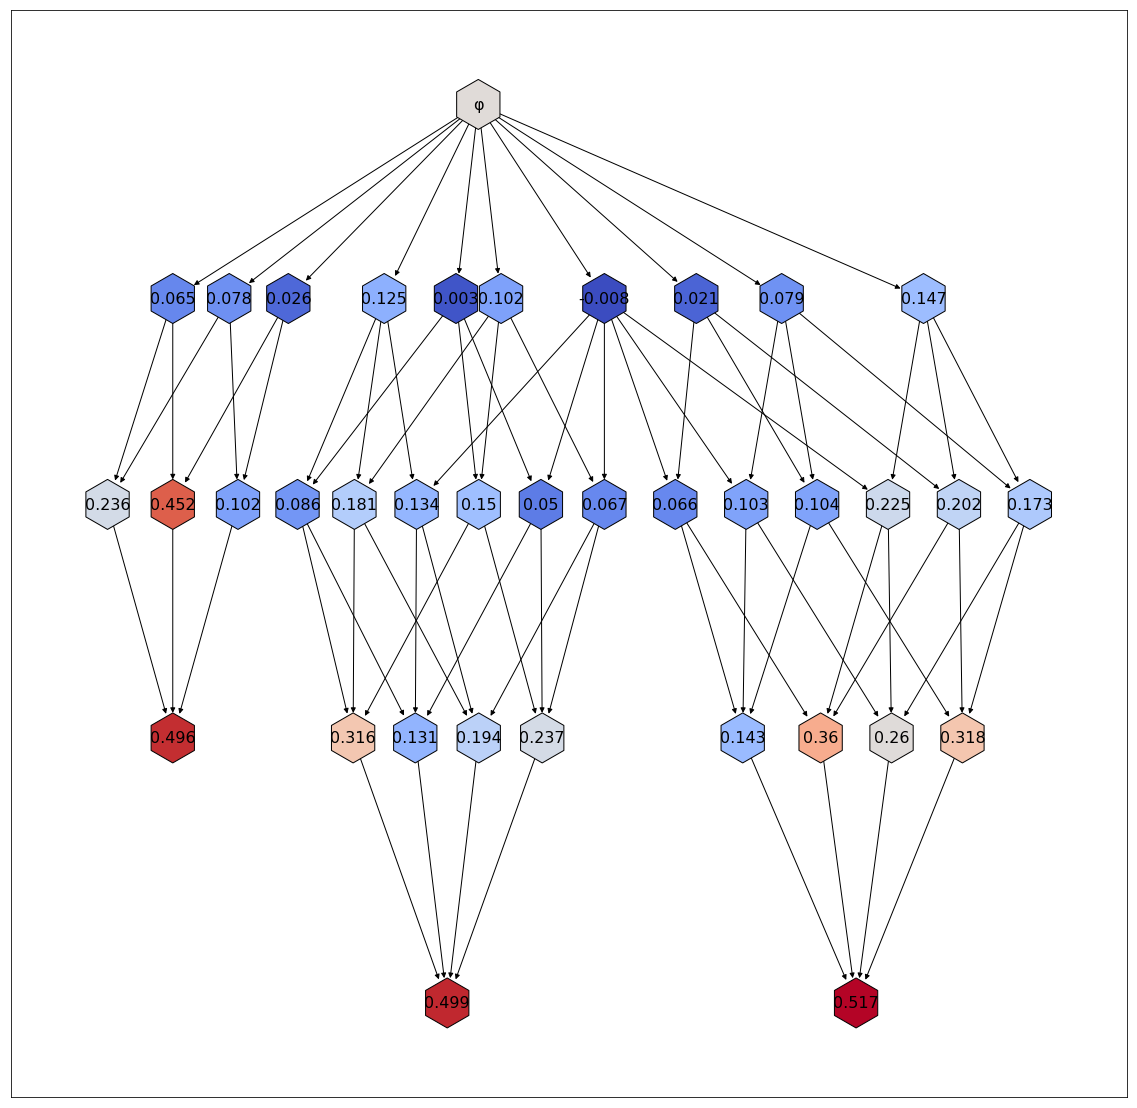

In [517]:
plt.figure(figsize=(20, 20))
options = {"with_labels": True, "node_color": "white", "edgecolors": "blue"}

pos = graphviz_layout(G, prog='dot', root=chr(966))

for level in range(1, 5):
    for node in node_dict[level]:
        node = '\n'.join(node)
        p = pos[node]
        pos[node] = (p[0], p[1]-level*50)

options = {
    'node_shape': 'h',
    'node_size': 2500,
#     "node_color": "blue",
    "edgecolors": "black",
    "font_size": 16
}
nx.draw_networkx(G, pos, node_color=color_map, cmap=plt.cm.coolwarm, with_labels=False, arrows=True, **options)

# nx.draw_networkx_nodes(G, pos, node_size=2800, alpha=0.4, node_shape='s', **options)
# nx.draw_networkx_edges(G, pos, min_source_margin=1000,  min_target_margin=1000)
nx.draw_networkx_labels(G, pos, labels=score_dict, font_color='black', font_size=16, font_family='sans-serif')
# plt.tight_layout()
plt.show()